In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import sys
import pathlib
import glob
import matplotlib.pyplot as plt
from urllib.parse import quote
from sqlalchemy import create_engine
import configparser


import statsmodels.api as sm
#import pingouin as pg
import plotly.express as px

In [2]:
sys.path.append("../../Micromet")
import micromet
from micromet import AmerifluxDataProcessor
from micromet import volumetric_heat_capacity, diurnal_amplitude, diurnal_peak_lag, soil_heat_flux, calculate_thermal_properties_for_all_pairs
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import correlate

# Function to decompose the seasonal component
def extract_seasonal(ts, period):
    decomposition = seasonal_decompose(ts, model='additive', period=period)
    return decomposition.seasonal

# Function to calculate lag between two seasonal series using cross-correlation
def calculate_lag(seasonal1, seasonal2):
    n = len(seasonal1)
    correlation = correlate(seasonal1 - np.mean(seasonal1), seasonal2 - np.mean(seasonal2), mode='full')
    lags = np.arange(-n + 1, n)
    lag = lags[np.argmax(correlation)]
    return lag, correlation, lags

ts1 = utd_soilt['ts_3_2_1']
ts2 = utd_soilt['ts_3_3_1']
#utd_soilt['ts_3_3_1'].shift(-5).plot()


# Extract seasonal components
seasonal1 = extract_seasonal(ts1, period=48)
seasonal2 = extract_seasonal(ts2, period=48)

# Calculate lag
lag, correlation, lags = calculate_lag(seasonal1.dropna(), seasonal2.dropna())

# Output
print(f"Calculated lag: {lag/2} hours")

# Plot seasonal components and correlation
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

seasonal1.plot(ax=ax[0], label='Seasonal Component 1')
seasonal2.plot(ax=ax[0], label='Seasonal Component 2')
ax[0].legend()
ax[0].set_title('Seasonal Components')
ax[0].set_xlim(pd.to_datetime('2024-07-01'),pd.to_datetime('2024-07-08'))
ax[0].grid(True)

ax[1].plot(lags, correlation)
ax[1].set_title('Cross-Correlation')
ax[1].set_xlabel('Lag (hours)')
ax[1].set_ylabel('Correlation')
ax[1].set_xlim(-10, 10)
ax[1].grid(True)

ax[2].plot(seasonal1.index, seasonal1, label='Series 1')
ax[2].plot(seasonal2.index + pd.Timedelta(hours=lag/2), seasonal2, label='Series 2 (Shifted)')
ax[2].legend()
ax[2].set_title(f'Series alignment (Lag: {lag/2} hours)')
ax[2].set_xlim(pd.to_datetime('2024-07-01'),pd.to_datetime('2024-07-08'))
ax[2].grid(True)
plt.tight_layout()
plt.show()



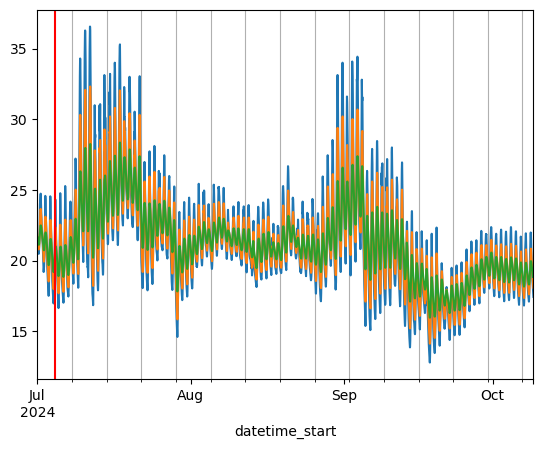

In [3]:
soildfs = pd.read_parquet('../station_data/all_soil_data.parquet')
utd_soilt = soildfs.loc['US-UTD'][['ts_3_1_1','ts_3_2_1','ts_3_3_1','swc_3_1_1','swc_3_2_1','swc_3_3_1']].replace(-9999,np.nan)
utd_soilt = utd_soilt[utd_soilt.index >= '2024-07-01']#.resample('30T').mean()
utd_soilt['ts_3_1_1'].plot()
utd_soilt['ts_3_2_1'].shift(-1).plot()
utd_soilt['ts_3_3_1'].shift(-5).plot()
plt.axvline('2024-07-04 15:00',color='r')
#plt.xlim('2024-07-01','2024-07-08')
#plt.ylim(10,35)
plt.grid(True, which='minor')

In [ ]:
ut_soilt = soildfs.loc['US-UTD'][['ts_3_1_1','ts_3_2_1','ts_3_3_1',
                                   'ts_3_4_1','ts_3_5_1','ts_3_6_1',
                                   'swc_3_1_1','swc_3_2_1','swc_3_3_1',
                                   'swc_3_4_1','swc_3_5_1','swc_3_6_1']].replace(-9999,np.nan)
ut_soilt = ut_soilt[ut_soilt.index >= '2024-07-01']#.resample('30T').mean()
#utd_soilt.to_parquet('utd_soil_data.parquet')
#utd_soilt.to_csv('utd_soil_data.csv')

In [5]:
# Define the mapping of column names to depths
depth_mapping = {'ts_3_1_1': 0.05, 'ts_3_2_1': 0.1, 'ts_3_3_1': 0.2, 'ts_3_4_1': 0.3, 'ts_3_5_1': 0.4, 'ts_3_6_1': 0.5} 

df = calculate_thermal_properties_for_all_pairs(utd_soilt, depth_mapping)
df.index.get_level_values(0).unique()

Index(['0.05-0.1', '0.05-0.2', '0.05-0.3', '0.05-0.4', '0.05-0.5', '0.1-0.2',
       '0.1-0.3', '0.1-0.4', '0.1-0.5', '0.2-0.3', '0.2-0.4', '0.2-0.5',
       '0.3-0.4', '0.3-0.5', '0.4-0.5'],
      dtype='object')

G_alpha_log
G_alpha_amp
G_alpha_lag


(-100.0, 150.0)

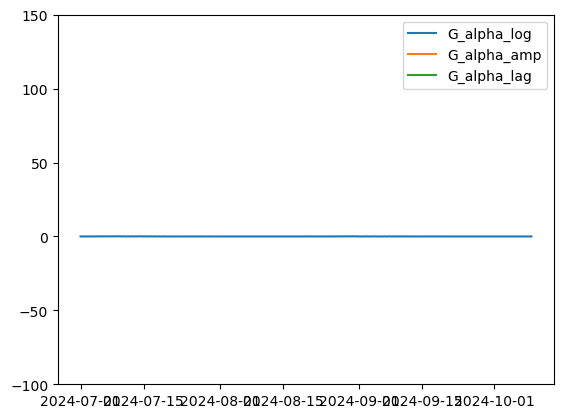

In [6]:
data = df.loc['0.05-0.1']
for col in data.columns:
    if 'G' in col:
        print(col)
        plt.plot(data.index, data[col], label=col)
plt.legend()
plt.ylim(-100, 150)

US-UTD
US-UTM
US-UTM
US-UTJ
US-CdM
US-UTE


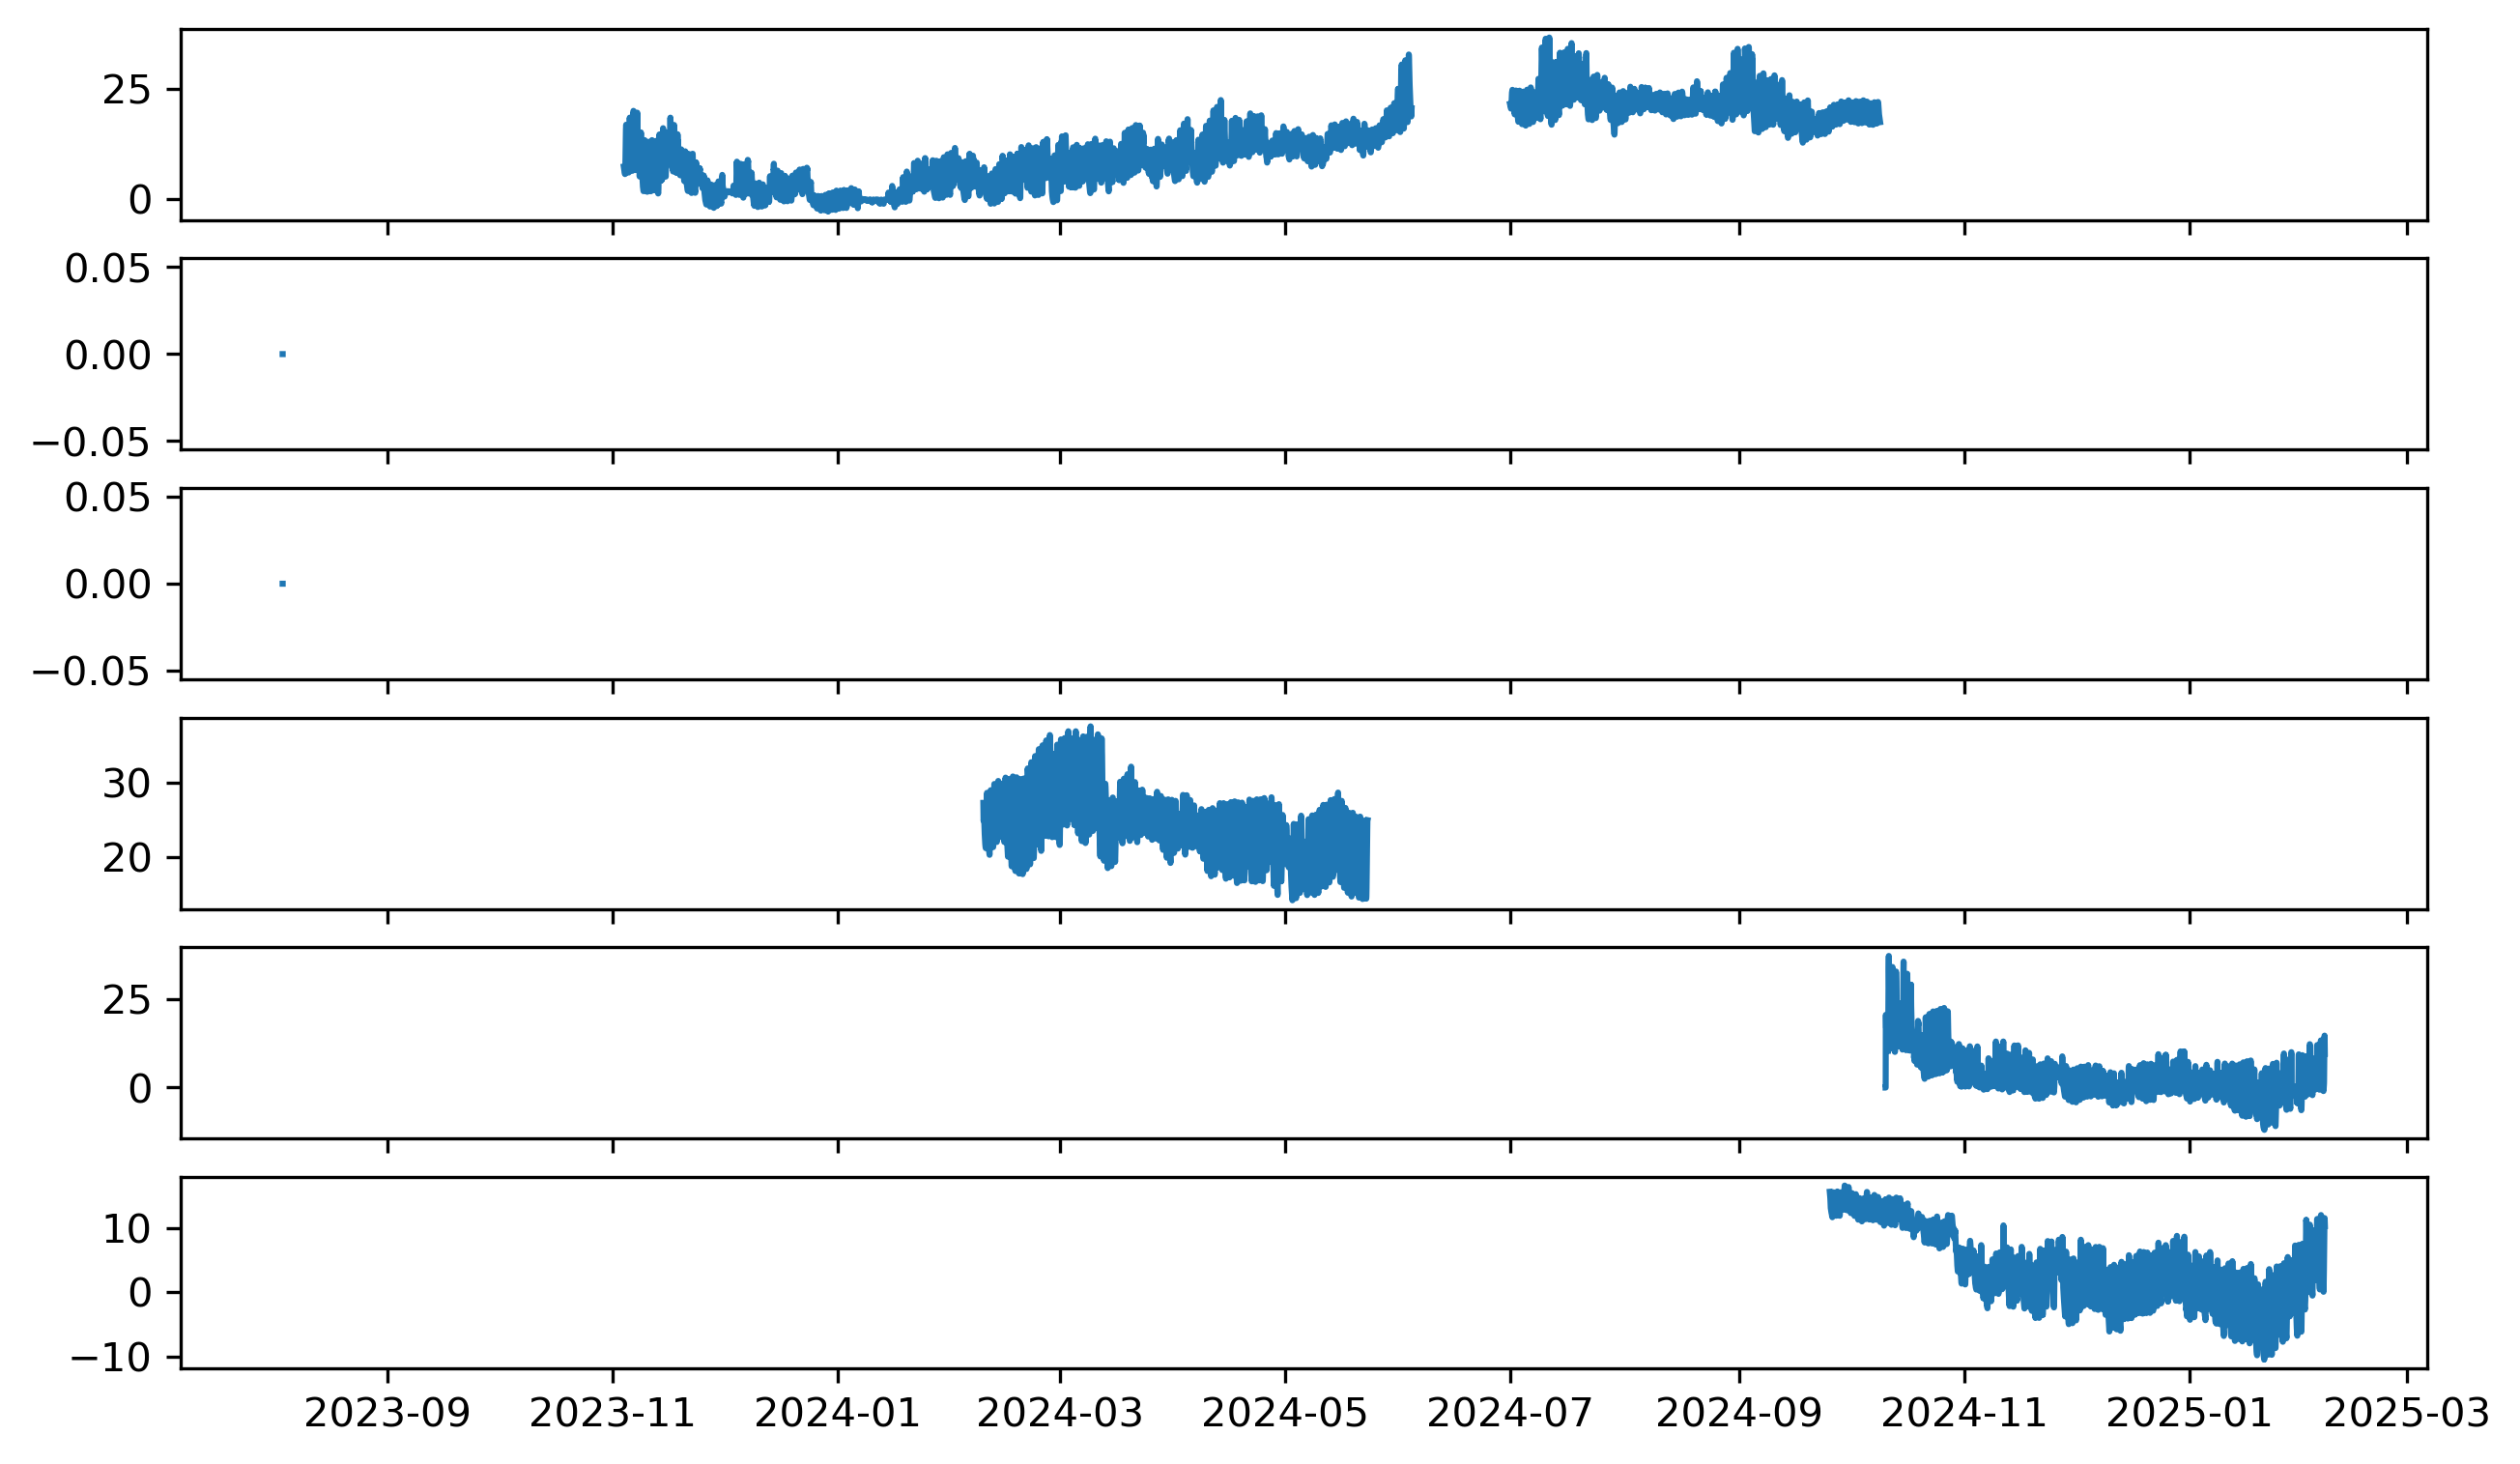

In [19]:
stations = ['US-UTD', 'US-UTM', 'US-UTM', 'US-UTJ', 'US-CdM','US-UTE',]

fig, ax = plt.subplots(6, 1, figsize=(10, 6), dpi=300, sharex=True)
i=0
for station in stations:
    print(station)
    df = soildfs.loc[station].replace(-9999,np.nan)
    #df = df[df.index >= '2024-07-01']#.resample('30T').mean()
    ax[i].plot(df.index, df['ts_3_1_1'], label=station)
    i+= 1

In [28]:
from micromet import thermal_diffusivity_amplitude, thermal_diffusivity_lag, thermal_conductivity, calc_thermal_diffusivity_log_pair

stations = ['US-UTD', 'US-UTM', 'US-UTM', 'US-UTJ', 'US-CdM','US-UTE',]

stations = ['US-UTD', 'US-UTM', 'US-UTM', 'US-UTJ', 'US-CdM','US-UTE',]

#fig, ax = plt.subplots(6, 1, figsize=(10, 6), dpi=300)
i=0
for station in stations:
    print(station)
    df = soildfs.loc[station].replace(-9999,np.nan)
    #df = df[df.index >= '2024-07-01']#.resample('30T').mean()
    #ax[i].plot(df.index, df['ts_3_1_1'], label=station)
    i+= 1
    ut_soilt = df[['ts_3_1_1','ts_3_2_1','ts_3_3_1',
                                    'ts_3_4_1','ts_3_5_1','ts_3_6_1',
                                    'swc_3_1_1','swc_3_2_1','swc_3_3_1',
                                    'swc_3_4_1','swc_3_5_1','swc_3_6_1']].replace(-9999,np.nan).dropna().resample('30min').interpolate(method='linear')
    #ut_soilt = ut_soilt[ut_soilt.index >= '2024-07-01']#.resample('30T').mean()

    z1 = 0.05
    z2 = 0.10
    z3 = 0.2
    z4 = 0.3

    series1 = ut_soilt['ts_3_1_1']
    series2 = ut_soilt['ts_3_2_1']
    series3 = ut_soilt['ts_3_3_1']
    series4 = ut_soilt['ts_3_4_1']  # This is not used in the calculations below but included for completeness

    # Calculate diurnal amplitude
    amp1 = diurnal_amplitude(series1)
    amp2 = diurnal_amplitude(series2)
    amp3 = diurnal_amplitude(series3)
    amp4 = diurnal_amplitude(series4)


    # Calculate α from amplitude
    alpha_amp_shallow = thermal_diffusivity_amplitude(amp1, amp2, z1, z2)
    alpha_amp_mid_1 = thermal_diffusivity_amplitude(amp1, amp3, z1, z3)
    alpha_amp_mid_2 = thermal_diffusivity_amplitude(amp2, amp3, z2, z3)
    alpha_amp_deep = thermal_diffusivity_amplitude(amp1, amp4, z1, z4)

    alpha_log_shallow = calc_thermal_diffusivity_log_pair(ut_soilt,'ts_3_1_1', 'ts_3_2_1', z1, z2)
    alpha_log_deep = calc_thermal_diffusivity_log_pair(ut_soilt,'ts_3_1_1', 'ts_3_3_1', z1, z3)

    # Volumnetric heat capacity
    Cv = volumetric_heat_capacity(ut_soilt[['swc_3_1_1','swc_3_2_1']].mean(axis=1)/100).resample('D').mean()

    # Estimate k (using average of both α estimates)

    k_amp_s = thermal_conductivity(alpha_amp_shallow, Cv).replace([np.inf, -np.inf], np.nan)#.mean()
    k_amp_m1 = thermal_conductivity(alpha_amp_mid_1, Cv).replace([np.inf, -np.inf], np.nan)#.mean()
    k_amp_m2 = thermal_conductivity(alpha_amp_mid_2, Cv).replace([np.inf, -np.inf], np.nan)#.mean()
    k_amp_d = thermal_conductivity(alpha_amp_deep, Cv).replace([np.inf, -np.inf], np.nan)#.mean()

    #k_log_s = thermal_conductivity(alpha_log_shallow, Cv).replace([np.inf, -np.inf], np.nan)#.mean()
    #k_log_d = thermal_conductivity(alpha_log_deep, Cv).replace([np.inf, -np.inf], np.nan)#.mean()
    #k_avg = thermal_conductivity(alpha_avg, Cv).replace([np.inf, -np.inf], np.nan).mean()
    print([k.mean() for k in [k_amp_s, k_amp_m1, k_amp_m2, k_amp_d,]]) #k_log_s, k_log_d]])


US-UTD
[np.float64(2.029366072196028), np.float64(4.567130720784632), np.float64(750.0699047030466), np.float64(126.43548556463605)]
US-UTM
[nan, nan, nan, nan]
US-UTM
[nan, nan, nan, nan]
US-UTJ
[np.float64(1.2910282061133256), np.float64(1.5489511988856526), np.float64(1.7376152030073102), np.float64(1.823751979155409)]
US-CdM
[np.float64(2.254358380988296), np.float64(45.2804956421429), np.float64(6.416547120974367), np.float64(370.38199502054107)]
US-UTE
[np.float64(0.6788128555315444), np.float64(1.0429249363077968), np.float64(1.4576343725930538), np.float64(1.4908427484901738)]


In [34]:
k_log_s

np.float64(5.504777341018457e-07)

In [37]:
kval['k_log_d']

np.float64(0.9837985397650775)

{'bodies': [<matplotlib.collections.FillBetweenPolyCollection at 0x1e588811e50>,
 'cmeans': <matplotlib.collections.LineCollection at 0x1e588812850>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1e588812990>,
 'cmins': <matplotlib.collections.LineCollection at 0x1e588812ad0>,
 'cbars': <matplotlib.collections.LineCollection at 0x1e588812c10>,
 'cmedians': <matplotlib.collections.LineCollection at 0x1e588812d50>}

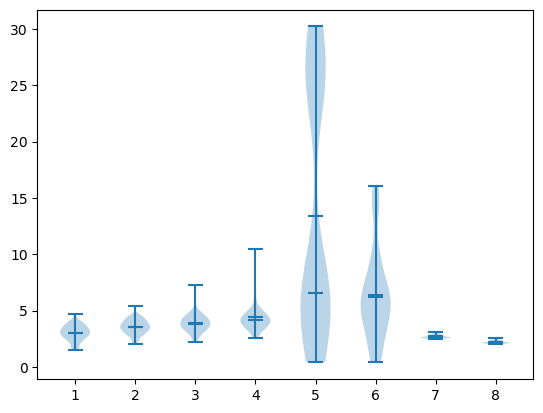

In [ ]:
kval={'k_amp_s':k_amp_s,
      'k_amp_m1':k_amp_m1,
      'k_amp_m2':k_amp_m2, 
      'k_amp_d':k_amp_d, 
      'k_log_s':k_log_s, 
      'k_log_d':k_log_d}
kdf = pd.DataFrame(kval).dropna()

plt.violinplot(kdf,showmeans=True, showmedians=True)

G_amp_s: 3.76 W/m²
G_amp_m1: 1.58 W/m²
G_amp_m2: 2.37 W/m²
G_amp_d: 1.17 W/m²
G_log_s: 3.30 W/m²


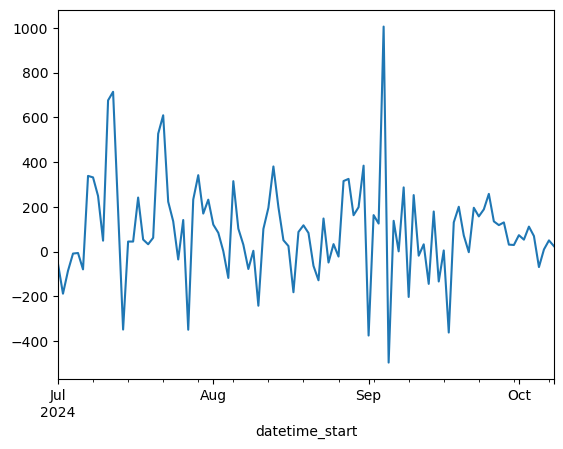

In [91]:
gval = {}

gval['G_amp_s'] = soil_heat_flux(utd_soilt['ts_3_1_1'], utd_soilt['ts_3_2_1'], z1, z2, k_amp_s.mean())#.plot(label='G shallow (amplitude)')
gval['G_amp_m1'] = soil_heat_flux(utd_soilt['ts_3_1_1'], utd_soilt['ts_3_3_1'], z1, z3, k_amp_m1.mean())#.plot(label='G deep (amplitude)')
gval['G_amp_m2'] = soil_heat_flux(utd_soilt['ts_3_1_1'], utd_soilt['ts_3_3_1'], z2, z3, k_amp_m1.mean())#.plot(label='G deep (amplitude)')
gval['G_amp_d'] = soil_heat_flux(utd_soilt['ts_3_1_1'], utd_soilt['ts_3_3_1'], z1, z4, k_amp_d.mean())#.plot(label='G deep (amplitude)')

gval['G_log_s'] = soil_heat_flux(utd_soilt['ts_3_1_1'], utd_soilt['ts_3_2_1'], z1, z2, k_log_s.mean())#.plot(label='G shallow (log)')
#gval['G_log_d'] = soil_heat_flux(utd_soilt['ts_3_1_1'], utd_soilt['ts_3_3_1'], z1, z3, k_log_d.mean())#.plot(label='G deep (log)')

#gval['G_lag_s'] = soil_heat_flux(utd_soilt['ts_3_1_1'], utd_soilt['ts_3_2_1'], z1, z2, k_lag_s.mean())#.plot(label='G shallow (log)')
#gval['G_lag_d'] = soil_heat_flux(utd_soilt['ts_3_1_1'], utd_soilt['ts_3_3_1'], z1, z3, k_lag_d.mean())#.plot(label='G deep (log)')

cdf = pd.read_parquet('../station_data/all_eddy_data.parquet')
shf = cdf.loc['US-UTD',:].loc['2024-07-01':'2024-10-08','g'].replace(-9999,np.nan)#.plot()
shf.resample('1d').sum().plot(label='SHF (g)')

for key, value in gval.items():
    print(f"{key}: {value.mean():.2f} W/m²")

gval_df = pd.concat([pd.DataFrame(gval), shf], axis=1).dropna()




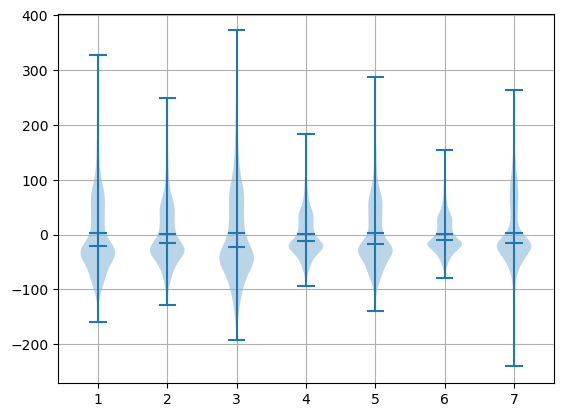

In [89]:
plt.violinplot(gval_df, showmeans=True, showmedians=True)
plt.grid()


<Axes: xlabel='datetime_start'>

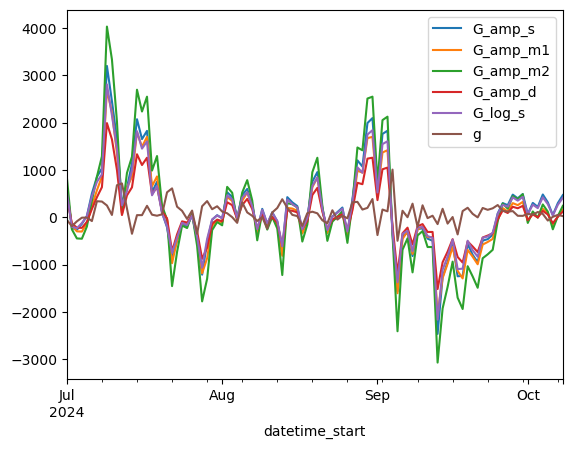

In [92]:

gval_df.resample('1D').sum().plot()
#plt.ylim(-2000,2000)

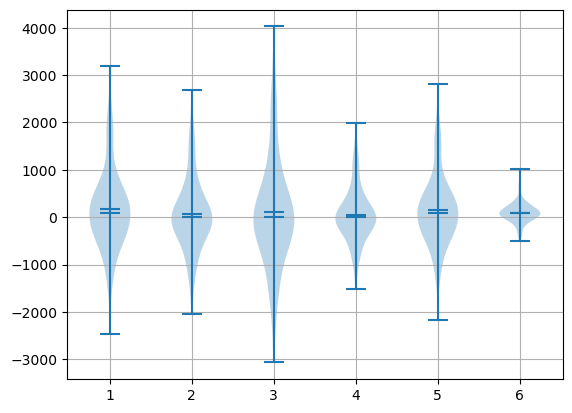

In [93]:
plt.violinplot(gval_df.resample('1D').sum(), showmeans=True, showmedians=True)
plt.grid()


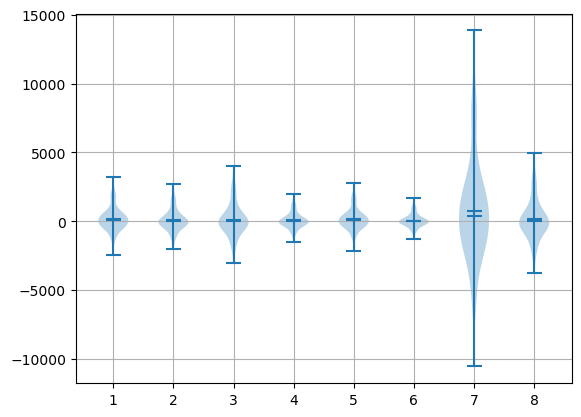

In [73]:
gval_df = pd.DataFrame(gval).dropna()

plt.violinplot(gval_df.resample('1D').sum(), showmeans=True, showmedians=True)
plt.grid()

In [ ]:
all_diff_log

<Axes: xlabel='datetime_start'>

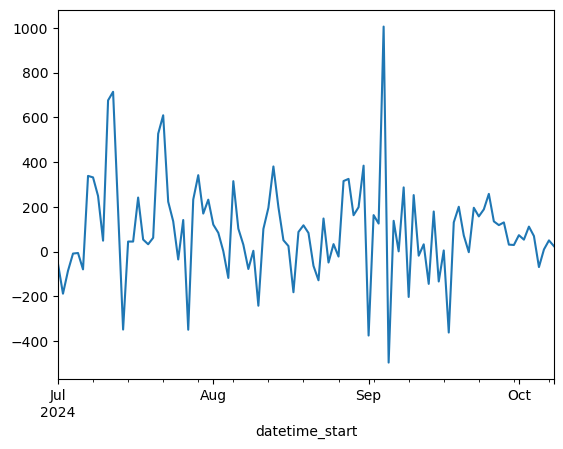

In [82]:
cdf = pd.read_parquet('../station_data/all_eddy_data.parquet')
shf = cdf.loc['US-UTD',:].loc['2024-07-01':'2024-10-08','g'].replace(-9999,np.nan)#.plot()
shf.resample('1d').sum().plot(label='SHF (g)')

In [ ]:
cdf